# 
<h1 style="color: teal;"><b>2D Deconvolution Benchmark: Julia</b></h1>

---
## Setup

<p style="color: red;"><b>IMPORTANTE: </b></p> Ejecutar las siguientes celdas antes de comenzar:

In [95]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW, NPZ,ImageView, PyPlot


Función Richardson-Lucy modificada:

In [131]:
function richardson_lucy_iterative2(measured, psf; 
    psf_bp=nothing,
    regularizer=nothing,
    λ=0.05,
    iterations=30,
    conv_dims=1:ndims(psf),
    threshold = 0,
    progress = nothing)

otf, conv_temp = plan_conv(measured, psf, conv_dims) 
# initializer
### Different PSF inizialization methods are possible generating custom psf_bp using the relative functions 
# if psf_bp == nothing
#     psf_bp = deepcopy(psf)
#     reverse!(psf_bp)
# end
# otf_conj, _ = plan_conv(measured, psf_bp, conv_dims) 
if psf_bp == nothing
otf_conj = conj.(otf)
else
otf_conj, _ = plan_conv(measured, psf_bp, conv_dims) 
end
# Apply threshold
rec =  map(x -> x >= threshold ? x : threshold, measured) 

#### THIS PART NEED TO BE DEBUGGED!!!
# buffer for gradient
# we need Base.invokelatest because of world age issues with generated
# regularizers
buffer_grad =  let 
if !isnothing(regularizer)
Base.invokelatest(DeconvOptim.gradient, regularizer, rec)[1]
else
nothing
end
end

∇reg(x) = buffer_grad .= Base.invokelatest(DeconvOptim.gradient, regularizer, x)[1]

buffer = copy(measured)

iter_without_reg(rec) = begin
buffer .= measured ./ (conv_temp(rec, otf))
conv_temp(buffer, otf_conj)
end
iter_with_reg(rec) = buffer .= (iter_without_reg(rec) .- λ .* ∇reg(rec))

iter = isnothing(regularizer) ? iter_without_reg : iter_with_reg

# the loss function is only needed for logging, not for LR itself
loss(myrec) = begin
fwd = conv_temp(myrec, otf)
return sum(fwd .- measured .* log.(fwd))
end

# logging part
tmp_time = 0.0
if progress !== nothing
record_progress!(progress, rec, 0, loss(rec), 0.0, 1.0)
tmp_time=time()
end
code_time = 0.0

# do actual optimization
for i in 1:iterations
rec .*= iter(rec)
if progress !== nothing
# do not count the time for evaluating the loss here.
code_time += time() .- tmp_time
record_progress!(progress, copy(rec), i, loss(rec), code_time, 1.0)
tmp_time=time()
end
end

return rec
end


richardson_lucy_iterative2 (generic function with 1 method)

In [132]:
function BackProjector(PSF_fp; bp_type="traditional", alpha=0.001, beta=1, n=10, resFlag=1, iRes=[0, 0, 0], verboseFlag=false)
    # Initialize dimensions
    dims = ndims(PSF_fp)
    if dims == 2
        Sx, Sy = size(PSF_fp)
        Sz = 1
    elseif dims == 3
        Sx, Sy, Sz = size(PSF_fp)
    else
        error("Input PSF must be 2D or 3D")
    end

    # Scx, Scy, Scz = (Sx + 1) / 2, (Sy + 1) / 2, (Sz + 1) / 2

    if verboseFlag
        println("Back projector type: $bp_type")
    end

    # Flip PSF
    flippedPSF = deepcopy(PSF_fp)
    reverse!(flippedPSF)

    if bp_type == "traditional"
        PSF_bp = flippedPSF
        OTF_bp = fft(ifftshift(PSF_bp))

    else

        # Fourier Transform of flipped PSF
        OTF_flip = fft(ifftshift(flippedPSF))
        OTF_abs = fftshift(abs.(OTF_flip))
        OTFmax = maximum(OTF_abs)

        if bp_type == "wiener"
            OTF_flip_norm = OTF_flip / OTFmax
            OTF_bp = OTF_flip_norm ./ (abs.(OTF_flip_norm).^2 .+ alpha)
            PSF_bp = fftshift(real(ifft(OTF_bp)))
        else

            # Resolution cutoff
            resx, resy, resz = if resFlag == 0
                FWHMx, FWHMy, FWHMz = size_to_fwhm(Sx, Sy, Sz)
                (FWHMx / √2, FWHMy / √2, FWHMz / √2)
            elseif resFlag == 1
                size_to_fwhm(Sx, Sy, Sz)
            elseif resFlag == 2
                dims == 2 ? (iRes[1], iRes[2], 0) : (iRes[1], iRes[2], iRes[3])
            else
                error("Invalid resFlag: $resFlag. Must be 0, 1, or 2.")
            end

            if bp_type == "gaussian"
                PSF_bp = gen_gaussianPSF(Sx, Sy, Sz, resx, resy, resz, dims)
                OTF_bp = fft(ifftshift(PSF_bp))
            else

                # Pixel size and frequency cutoff
                px, py, pz = 1 / Sx, 1 / Sy, 1 / max(1, Sz)
                tx, ty, tz = 1 / (resx * px), 1 / (resy * py), 1 / (resz * pz)

                if verboseFlag
                    println("Resolution cutoff (spatial): $resx x $resy x $resz")
                    println("Resolution cutoff (Fourier): $tx x $ty x $tz")
                end

                PSF_bp, OTF_bp = nothing, nothing

                # Process each back projector type
                
                if bp_type == "butterworth"
                    PSF_bp, OTF_bp = butterworth_filter(Sx, Sy, Sz, tx, ty, tz, beta, n, dims)
                elseif bp_type == "wiener-butterworth"
                    OTF_abs_norm = OTF_abs / OTFmax
                    PSF_bp, OTF_bp = wiener_butterworth_filter(OTF_flip, OTF_abs_norm, alpha, beta, Sx, Sy, Sz, tx, ty, tz, n, dims)
                else
                    error("Unsupported bp_type: $bp_type")
                end
            end
        end
    end

    return convert(typeof(PSF_fp), PSF_bp), OTF_bp
end


BackProjector (generic function with 1 method)

### Generación de imagen borrosa y PSF (imagen resolution_test_512)

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

In [98]:
# Cargar la imagen de prueba
img = testimage("resolution_test_512")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Normalizar la PSF para que conserve la energía
psf_normalized = psf ./ sum(psf)

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)

# Crear una versión borrosa y ruidosa de la imagen
img_b = imfilter(img, centered_psf)   # Imagen borrosa
img_n = poisson(img_b, 300)           # Imagen borrosa y ruidosa
;

# Guardar la PSF para los test
#npzwrite("test_psf.npy", centered_psf)

# Guardar la PSF de manera visible
#psf_vis = centered_psf ./ maximum(centered_psf)   # escala entre 0 y 1
#save("psf_visual.png", psf_vis)

# Guardar la imagen borrosa y ruidosa para test
#npzwrite("imagen_borrosa.npy", img_b)

# Guardar la imagen borrosa y ruidosa para visualizacion
#save("blurrednoisy_img.png", img_b)


In [121]:
# Gray.([img img_n psf_vis])

## 
<hr style="border: 6px solid teal;">
<h1 style="color: teal;"><b>Test Image</b></h1>


### Cargamos la imagen y la PSF que se van a emplear

In [133]:
img_n_1 = load("ImagenesEmpleadas2D/imagen_borrosa.npy")
img_n_1 = Float32.(img_n_1)

psf_1 = load("ImagenesEmpleadas2D/test_psf.npy")
psf_1 = Float32.(psf_1);

Richardson-Lucy del módulo DeconvOptim.jl modificada:

In [134]:
# Deconvolución 2D sin regularizador
res_no_reg= richardson_lucy_iterative2(img_n_1, ifftshift(psf_1), regularizer=nothing, iterations=30);

Richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [139]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n_1, ifftshift(psf_1); regularizer=nothing, iterations=30, λ=0.05);

Visualización de las imágenes:

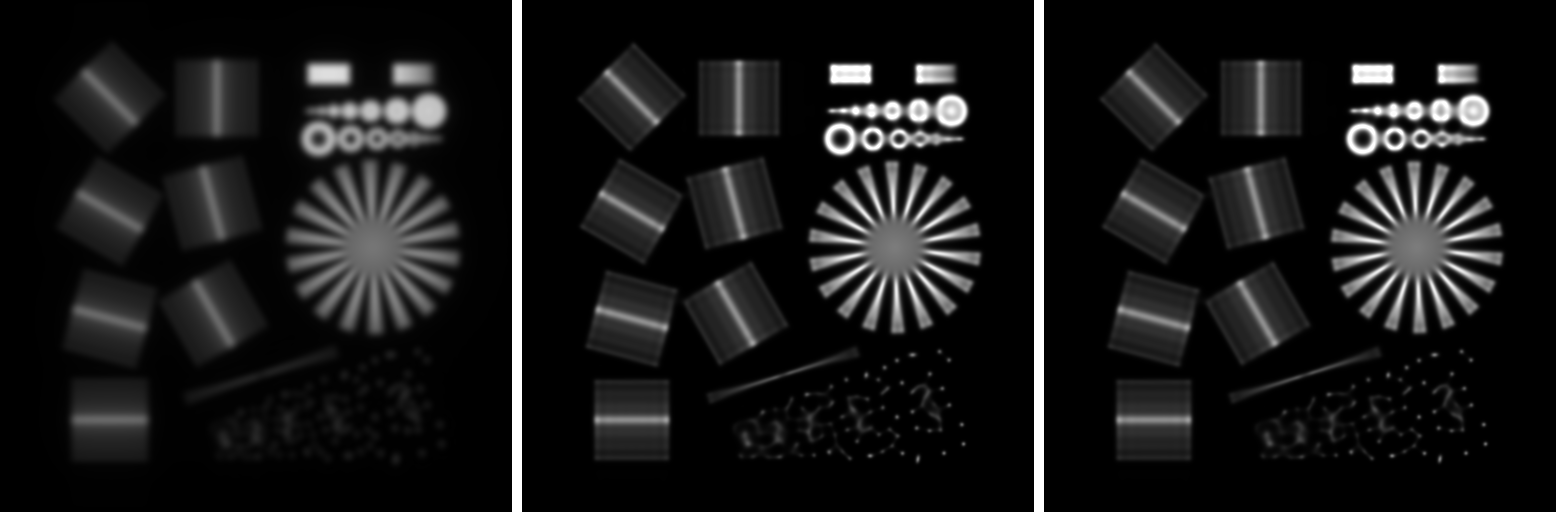

In [140]:
# Crear separador (blanco)
sep = fill(1.0f0, rows, 10)  # 10 píxeles de ancho

# Concatenar las imágenes con separadores
img_concat = hcat(img_n_1, sep, res_no_reg, sep, restored_img)

# Convertir a Gray
img_gray = Gray.(img_concat)

# Mostrar
display(img_gray)



In [127]:
using FileIO
using ImageCore

# Asegurar que los valores están en el rango [0,1]
res_no_reg_clamped   = colorview(Gray, N0f8.(clamp01nan.(res_no_reg)))
restored_img_clamped = colorview(Gray, N0f8.(clamp01nan.(restored_img)))

# Guardar las imágenes en formato PNG
save("resultado_sin_regularizacion.png", res_no_reg_clamped)
save("imagen_restaurada.png", restored_img_clamped)


<h3 style="color: green;">@ Benchmark</h3>

Richardson-Lucy modificada:

In [104]:
# Medir el tiempo de ejecución de la deconvolución
b = @benchmark  richardson_lucy_iterative2(img_n_1, ifftshift(psf_1), regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 82 samples with 1 evaluation.
 Range (min … max):  59.379 ms … 70.712 ms  ┊ GC (min … max): 0.00% … 15.45%
 Time  (median):     59.762 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   60.292 ms ±  1.968 ms  ┊ GC (mean ± σ):  0.64% ±  2.59%

  ▆█▇▄                                                         
  ██████▅▇▅▁▁▅▅▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▅ ▁
  59.4 ms      Histogram: log(frequency) by time      69.9 ms <

 Memory estimate: 8.02 MiB, allocs estimate: 96.

Richardson-Lucy sin modificar:

In [105]:
c = @benchmark richardson_lucy_iterative(img_n_1, ifftshift(psf_1); regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 84 samples with 1 evaluation.
 Range (min … max):  58.616 ms …  60.554 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     58.913 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.008 ms ± 376.254 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄ ▁▁  ▄▁▄█ █▄▄                                                
  █▇██▇▄████▄███▆▄▁▄▆▁▄▁▁▄▄▁▄▆▁▁▁▁▁▁▁▄▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▄ ▁
  58.6 ms         Histogram: frequency by time         60.5 ms <

 Memory estimate: 8.01 MiB, allocs estimate: 35.

---

Veremos ahora ejemplos con TV regularization en Julia

In [106]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#187 (generic function with 1 method)

Richardson-Lucy modificada:

In [107]:
res_mod_tv = richardson_lucy_iterative2(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=tv, iterations=30);

Richardson-Lucy sin modificar:

In [108]:
optim_res = richardson_lucy_iterative(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=tv, iterations=30);

In [128]:
# Asegurar que los valores están en el rango [0,1]
res_mod_tv_clamped   = colorview(Gray, N0f8.(clamp01nan.(res_mod_tv)))
optim_res_clamped = colorview(Gray, N0f8.(clamp01nan.(optim_res)))

# Guardar las imágenes en formato PNG
save("2DJULIA_testimage_reg_modificada.png", res_mod_tv_clamped)
save("2DJULIA_testimage_reg_original.png", optim_res_clamped)

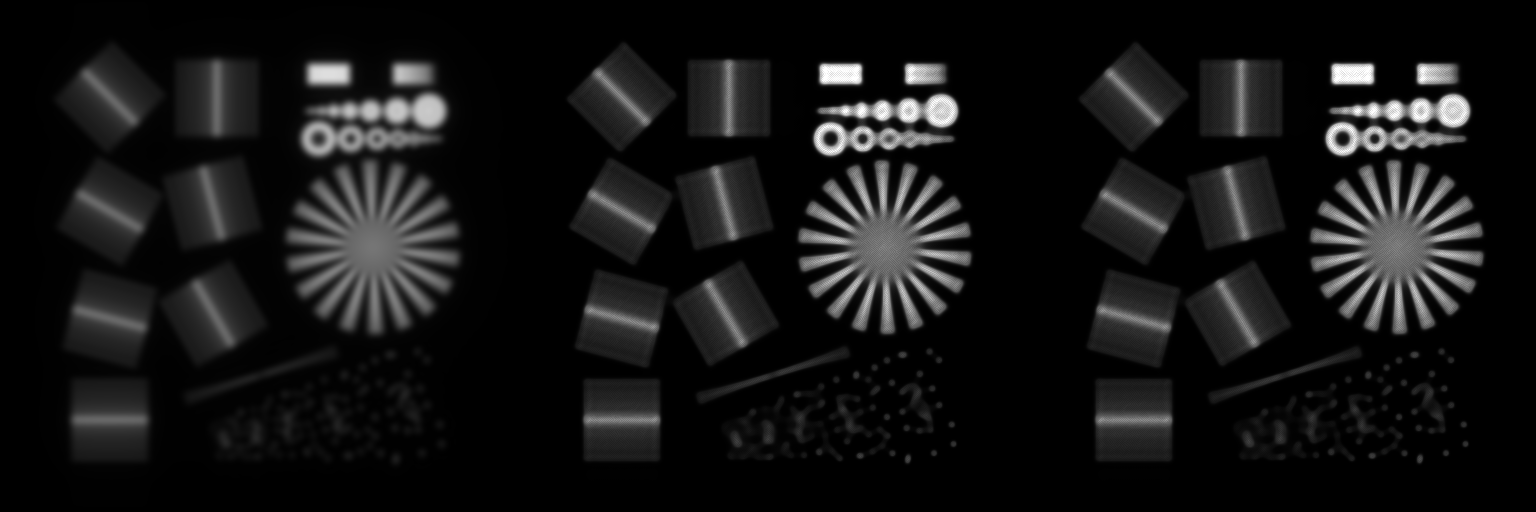

In [109]:
Gray.([img_n_1 optim_res res_mod_tv])

<h3 style="color: green;">@ Benchmark</h3>

In [110]:
d2_mod = @benchmark richardson_lucy_iterative2(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 64 samples with 1 evaluation.
 Range (min … max):  76.219 ms … 94.088 ms  ┊ GC (min … max): 0.00% … 16.21%
 Time  (median):     77.110 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.896 ms ±  2.471 ms  ┊ GC (mean ± σ):  1.08% ±  2.50%

     █▅▄ ▁  ▁                                                  
  ▃▃▆███▆█▃██▃▁▃▅▁▅▃▁▁▁▁▁▆▁▁▃▃▁▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  76.2 ms         Histogram: frequency by time        84.5 ms <

 Memory estimate: 39.04 MiB, allocs estimate: 1090.

In [111]:
d2 = @benchmark richardson_lucy_iterative(img_n_1, ifftshift(psf_1), λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 61 samples with 1 evaluation.
 Range (min … max):  76.731 ms … 269.008 ms  ┊ GC (min … max): 0.00% … 70.79%
 Time  (median):     77.965 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   81.773 ms ±  24.417 ms  ┊ GC (mean ± σ):  4.56% ±  9.09%

           █▂▂       ▂                                          
  ▄▁▄▁▅▄▁▇▅███▇▁▄▇▄▄▄█▄▁▁▄▁▄▁▄▁▁▁▁▄▄▄▁▁▄▁▁▁▁▁▁▄▁▁▄▄▁▄▅▁▁▄▁▁▁▁▄ ▁
  76.7 ms         Histogram: frequency by time         82.8 ms <

 Memory estimate: 39.04 MiB, allocs estimate: 1059.

## 
<hr style="border: 6px solid teal;">
<h1 style="color: teal;"><b>Cell</b></h1>

Test usando solo el plano central del `cells3D` dataset

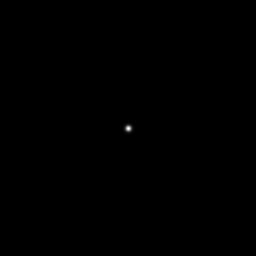

In [112]:
img = load("ImagenesEmpleadas2D/2d_cell_imgborrosa.npy")
img = Float32.(img)

psf = load("ImagenesEmpleadas2D/2d_cell_psf_test.npy")
psf = Float32.(psf)

Gray.(psf/maximum(psf))

In [113]:
ipsf = ifftshift(psf);

Richardson-Lucy modificada:

In [114]:
cell_mod = richardson_lucy_iterative2(img, ipsf; regularizer=nothing, iterations=30);

Richardson-Lucy sin modificar:

In [115]:
cell_nomod = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

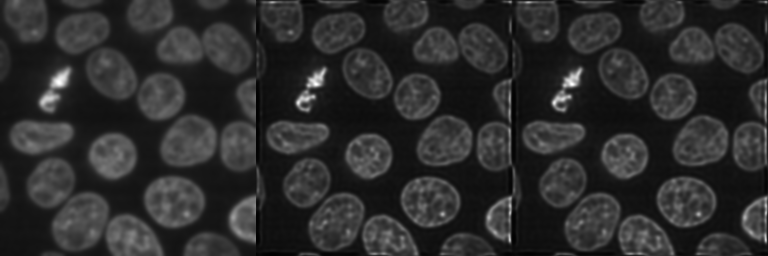

In [116]:
Gray.([img/maximum(img) cell_mod/maximum(cell_mod) cell_nomod/maximum(cell_nomod)])

In [152]:
# Asegurar que los valores están en el rango [0,1]
cell_mod_clamped   = colorview(Gray, N0f8.(clamp01nan.(cell_mod/maximum(cell_mod))))
#optim_res_clamped = colorview(Gray, N0f8.(clamp01nan.(optim_res)))

# Guardar las imágenes en formato PNG
save("2DJULIA_cell_modificada.png", cell_mod_clamped)
#save("2DJULIA_cell_original.png", optim_res_clamped)

<h3 style="color: green;">@ Benchmark</h3>

Richardson-Lucy modificada:

In [117]:
t = @benchmark richardson_lucy_iterative2(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  15.503 ms … 16.081 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.621 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.628 ms ± 70.857 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▃▁▃▃▃  ▄▆▁▄▁█▆   ▁                                 
  ▄▁▁▁▁▁▄▆▇▇█████▆▆███████▇▄▇█▄▄▄▄▁▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▄▁▁▁▁▄ ▄
  15.5 ms         Histogram: frequency by time        15.9 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 94.

Richardson-Lucy sin modificar:

In [118]:
tmod = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  15.289 ms …  15.946 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.394 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.419 ms ± 107.235 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▂ ▅▃▅▆█▃▃▆          ▂                                      
  ▅▅▁█▅████████▅▁▅▅█▇▇▄▅▅█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▄▁▁▁▁▁▁▁▁▄ ▄
  15.3 ms         Histogram: frequency by time         15.9 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

Ahora con TV regularization:

In [153]:
cell_mod_reg = richardson_lucy_iterative2(img, ipsf; regularizer=tv, iterations=30);

In [154]:
cell_nomod_reg = richardson_lucy_iterative(img, ipsf; regularizer=tv, iterations=30);

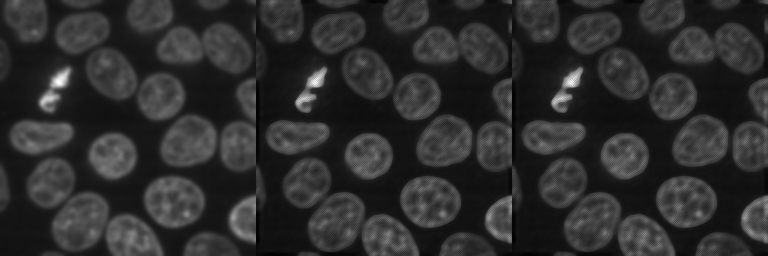

In [155]:
Gray.([img/maximum(img) cell_mod_reg/maximum(cell_mod_reg) cell_nomod_reg/maximum(cell_nomod_reg)])

In [158]:
# Asegurar que los valores están en el rango [0,1]
cell_mod_reg_clamped   = colorview(Gray, N0f8.(clamp01nan.(cell_mod_reg/maximum(cell_mod_reg))))

# Guardar las imágenes en formato PNG
save("2DJULIA_cell_reg_modificada.png", cell_mod_reg_clamped)


<h3 style="color: green;">@ Benchmark</h3>

In [156]:
t_reg = @benchmark richardson_lucy_iterative2(img, ipsf; regularizer=tv, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  19.878 ms … 342.009 ms  ┊ GC (min … max):  0.00% … 93.96%
 Time  (median):     20.360 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   23.731 ms ±  32.157 ms  ┊ GC (mean ± σ):  13.81% ±  9.67%

     █▆▃▂                                                       
  ▄▄▅████▃▃▃▁▁▄▄▁▁▁▁▁▁▁▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  19.9 ms         Histogram: frequency by time         26.2 ms <

 Memory estimate: 9.53 MiB, allocs estimate: 1088.

In [157]:
tmod_reg = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=tv, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  19.794 ms … 223.083 ms  ┊ GC (min … max): 0.00% … 90.78%
 Time  (median):     20.374 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.414 ms ±  20.275 ms  ┊ GC (mean ± σ):  9.23% ±  9.24%

         █▂                                                     
  ▅▂▂▃█▄▅██▇▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  19.8 ms         Histogram: frequency by time         24.5 ms <

 Memory estimate: 9.53 MiB, allocs estimate: 1057.

---

Prueba que demuestra que la función adaptada no es necesario aplicar un flitro gaussiano al inicializar:

In [148]:
using DeconvOptim
using BenchmarkTools
using ImageCore, FileIO, ImageIO
using Statistics
using LinearAlgebra
using CSV, DataFrames
# Si tienes ImageQualityIndexes.jl o ImageDistances.jl, coméntalo aquí y úsalo para SSIM
# using ImageQualityIndexes  # opcional

# --- utilidades ---
function ensure_folder(dir)
    isdir(dir) || mkdir(dir)
end

# guarda imagen clamp-ada y en N0f8 (grayscale)
function save_png_gray(path, img)
    imgc = clamp01nan.(img)                      # recorta a [0,1] y NaN->0
    img8 = N0f8.(imgc)                           # convertir a 8-bit
    save(path, colorview(Gray, img8))
end

# PSNR manual (asumiendo imágenes en [0,1])
function psnr(img1, img2; maxval=1.0)
    mse = mean((Float64.(img1) .- Float64.(img2)).^2)
    return iszero(mse) ? Inf : 10*log10(maxval^2 / mse)
end

# wrapper para ejecutar un experimento y recoger métricas
function run_experiment(fn_sym; measured, psf, regularizer=nothing, λ=0.05, iterations=30, conv_dims=1:ndims(psf))
    # construir la llamada (dos funciones: richardson_lucy_iterative o richardson_lucy_iterative2)
    fn = getfield(Main, fn_sym)  # asume que la función está en Main
    # Warm-up una ejecución rápida (evita incluir compilación en las mediciones)
    _ = fn(measured, psf; regularizer=regularizer, λ=λ, iterations=1, conv_dims=conv_dims)
    # Benchmark
    b = @benchmark $fn($measured, $psf; regularizer=$regularizer, λ=$λ, iterations=$iterations, conv_dims=$conv_dims) samples=100 evals=1
    # obtener mediana en segundos (b.times está en ns)
    med_ns = median(b.times)
    med_s = med_ns / 1e9
    # intentar obtener memoria/allocs desde el Trial (si están disponibles)
    mem_est = try
        b.memory
    catch
        nothing
    end
    
    allocs_est = try
        b.allocs
    catch
        nothing
    end    
    # ejecutar una vez para obtener la imagen resultante
    result = fn(measured, psf; regularizer=regularizer, λ=λ, iterations=iterations, conv_dims=conv_dims)
    return (result=result, med_time_s=med_s, mem_est=mem_est, allocs_est=allocs_est, bench=b)
end

# --- ejemplo de uso (ajusta rutas/variables) ---
function full_benchmark_pipeline()
    ensure_folder("Figures")
    # Cargar imágenes (ajusta rutas)
    img_b = Float32.(load("ImagenesEmpleadas2D/imagen_borrosa.npy"))
    psf = Float32.(load("ImagenesEmpleadas2D/test_psf.npy"))
    ipsf = ifftshift(psf)

    # definiciones de configuración
    iterations_list = [10, 30, 60, 100]
    results_table = []  # almacenar tuplas para luego salvar CSV

    for it in iterations_list
        ## 1) Original sin regularizar
        r1 = run_experiment(:richardson_lucy_iterative, measured=img_b, psf=ipsf, regularizer=nothing, λ=0.05, iterations=it)
        save_png_gray("Figures/img_orig_noreg_iter$(it).png", r1.result)
        # diferencias respecto a la imagen borrosa (o vs ground truth si la tienes)
        save_png_gray("Figures/img_orig_noreg_iter$(it)_diff.png", abs.(r1.result .- img_b))
        push!(results_table, ("imagen_borrosa", "original", "noreg", it, r1.med_time_s, r1.mem_est, r1.allocs_est, psnr(r1.result, img_b)))
        ## 2) Adaptada sin regularizar
        r2 = run_experiment(:richardson_lucy_iterative2, measured=img_b, psf=ipsf, regularizer=nothing, λ=0.05, iterations=it)
        save_png_gray("Figures/img_adapt_noreg_iter$(it).png", r2.result)
        save_png_gray("Figures/img_adapt_noreg_iter$(it)_diff.png", abs.(r2.result .- img_b))
        push!(results_table, ("imagen_borrosa", "adaptada", "noreg", it, r2.med_time_s, r2.mem_est, r2.allocs_est, psnr(r2.result, img_b)))
        ## 3) Original con TV
        tv = TV()  # si usas DeconvOptim.TV
        r3 = run_experiment(:richardson_lucy_iterative, measured=img_b, psf=ipsf, regularizer=tv, λ=0.05, iterations=it)
        save_png_gray("Figures/img_orig_tv_iter$(it).png", r3.result)
        save_png_gray("Figures/img_orig_tv_iter$(it)_diff.png", abs.(r3.result .- img_b))
        push!(results_table, ("imagen_borrosa", "original", "TV", it, r3.med_time_s, r3.mem_est, r3.allocs_est, psnr(r3.result, img_b)))
        ## 4) Adaptada con TV
        r4 = run_experiment(:richardson_lucy_iterative2, measured=img_b, psf=ipsf, regularizer=tv, λ=0.05, iterations=it)
        save_png_gray("Figures/img_adapt_tv_iter$(it).png", r4.result)
        save_png_gray("Figures/img_adapt_tv_iter$(it)_diff.png", abs.(r4.result .- img_b))
        push!(results_table, ("imagen_borrosa", "adaptada", "TV", it, r4.med_time_s, r4.mem_est, r4.allocs_est, psnr(r4.result, img_b)))
    end

    # Opcional: guardar CSV con resultados

    df = DataFrame(image=String[], implementation=String[], reg=String[], iterations=Int[], time_s=Float64[], mem=Union{Int,Nothing}[], allocs=Union{Int,Nothing}[], psnr=Float64[])
    for row in results_table
        push!(df, (row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8]))
    end
    CSV.write("Figures/julia_bench_results.csv", df)
    println("Pipeline completado. Resultados en ./Figures/ y ./Figures/julia_bench_results.csv")
end

# Ejecuta:
# full_benchmark_pipeline()


full_benchmark_pipeline (generic function with 1 method)

In [149]:
full_benchmark_pipeline()

Pipeline completado. Resultados en ./Figures/ y ./Figures/julia_bench_results.csv
